# Final Project : Parallelizing Text-to-Image Generation Using Diffusion 

Team 21: Abdul Azeem Syed and Ramshankar Bhuvaneswaran 

In [13]:
# Importing essential libraries and setting up the environment for the project.
import os
CUDA_LAUNCH_BLOCKING = 1 # Ensures that CUDA operations are performed synchronously

In [14]:
import pickle
import numpy as np
import random
from collections import defaultdict
import multiprocessing as mp
from pathlib import Path
from typing import List, Dict, Any
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [15]:
import warnings
warnings.filterwarnings('ignore')

# Verification of the dataset

In [6]:
def load_pickle(file_path):
    print(f"Loading pickle file from: {file_path}")
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
        
    print(f"\nDataset Overview:")
    print(f"Total number of samples: {len(data)}")
    sample = data[0]
    print("\nData structure:")
    
    for key, value in sample.items():
        if isinstance(value, np.ndarray):
            print(f"{key}: numpy array of shape {value.shape}, dtype {value.dtype}")
        else:
            print(f"{key}: {type(value)}")

load_pickle("data/coco_people_filtered_train2014.pkl")

Loading pickle file from: data/coco_people_filtered_train2014.pkl

Dataset Overview:
Total number of samples: 48339

Data structure:
image_path: <class 'str'>
image: <class 'PIL.Image.Image'>
caption: <class 'numpy.str_'>


In [16]:
def time_to_seconds(time_str):
    try:
        t = datetime.strptime(time_str, "%H:%M:%S")
        return t.hour * 3600 + t.minute * 60 + t.second
    except ValueError:
        try:
            t = datetime.strptime(time_str, "%M:%S")
            return t.minute * 60 + t.second
        except ValueError:
            print(f"Error parsing time: {time_str}")
            return 0

# Pre Process

**Approach**: 

We employ a diffusion-based text-to-image generation model, focusing specifically on the preprocessing pipeline. The pipeline consists of two main stages: 

**Image Preprocessing Using VAE**: 

We use a pretrained VAE to convert images into latent embeddings. These compact representations are crucial for downstream training tasks and help reduce memory load. 

**Text Preprocessing Using CLIP**: 

We use a pretrained CLIP model to generate text embeddings and attention masks from image captions. These embeddings guide the diffusion model’s attention mechanisms to ensure the model focuses on relevant textual tokens. 

**Parallelization Strategies**: 

- CPU-Based Parallelism: 

    We experimented with different degrees of parallelization on CPU: 

    Using 1, 2, 4, and 8 CPUs. 

    Implementing three main approaches: 

    - Native Multiprocessing (Python multiprocessing): Distributing the embedding tasks across multiple CPU processes. 

    - Joblib: A Python library designed for easy and optimized parallel computing. 

    - Dask: A Package to bypass Python's GIL

    We measured the total preprocessing time, speedup, and efficiency for each configuration, identifying which approach scales better as we increase CPU count. 

- GPU-Based Parallelism: 

    For comparison, we also evaluated the performance on 1, 2, 3, and 4 GPUs. We employed multithreading and distributed data loading to fully utilize GPU parallel capabilities. 

## using multiprocessing

In [5]:
!python img-multi/multi.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed_2cpu.pkl --num-cpus 1 --num-images 100

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Loading data from data/coco_people_filtered_train2014.pkl
Processing 100 images using 1 CPUs
Processed chunk 1/1
Saving results...

Processing Summary:
Total time: 0:04:59
Successfully processed: 100 images
Failed to process: 0 images
Average time per image: 2.994 seconds
Overall speed: 0.33 images/second


In [6]:
!python img-multi/multi.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed_2cpu.pkl --num-cpus 2 --num-images 100

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Loading data from data/coco_people_filtered_train2014.pkl
Processing 100 images using 2 CPUs
Processed chunk 1/2
Processed chunk 2/2
Saving results...

Processing Summary:
Total time: 0:05:23
Successfully processed: 100 images
Failed to process: 0 images
Average time per image: 3.232 seconds
Overall speed: 0.31 images/second


In [7]:
!python img-multi/multi.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed_2cpu.pkl --num-cpus 4 --num-images 100

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Loading data from data/coco_people_filtered_train2014.pkl
Processing 100 images using 4 CPUs
Processed chunk 1/4
Processed chunk 2/4
Processed chunk 3/4
Processed chunk 4/4
Saving results...

Processing Summary:
Total time: 0:05:39
Successfully processed: 100 images
Failed to process: 0 images
Average time per image: 3.390 seconds
Overall speed: 0.29 images/second


In [8]:
!python img-multi/multi.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed_2cpu.pkl --num-cpus 8 --num-images 100

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Loading data from data/coco_people_filtered_train2014.pkl
Processing 100 images using 8 CPUs
Processed chunk 1/8
Processed chunk 2/8
Processed chunk 3/8
Processed chunk 4/8
Processed chunk 5/8
Processed chunk 6/8
Processed chunk 7/8
Processed chunk 8/8
Saving results...

Processing Summary:
Total time: 0:05:57
Successfully processed: 100 images
Failed to process: 0 images
Average time per image: 3.572 seconds
Overall speed: 0.28 images/second


## Analysis of Speed up and efficiency with comparision for mp in image embeddings

In [38]:
cpu_counts = np.array([1, 2, 4, 8])  # Number of CPUs
execution_times_str = np.array(["0:04:59", "0:05:23" , "0:05:39", "0:05:57"])  # Execution times in seconds
execution_times = np.array([time_to_seconds(t) for t in execution_times_str])
base_time = execution_times[0]  # Sequential execution time (1 CPU)
speedup = base_time / execution_times
efficiency = speedup / cpu_counts

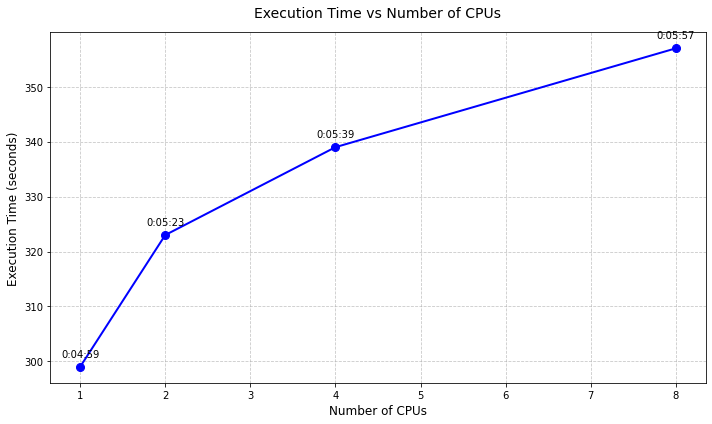

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(cpu_counts, execution_times, 'bo-', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of CPUs', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.title('Execution Time vs Number of CPUs', fontsize=14, pad=15)

# Add value labels
for i, (cpu, time) in enumerate(zip(cpu_counts, execution_times_str)):
    plt.annotate(time, (cpu, execution_times[i]), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

plt.tight_layout()
plt.show()

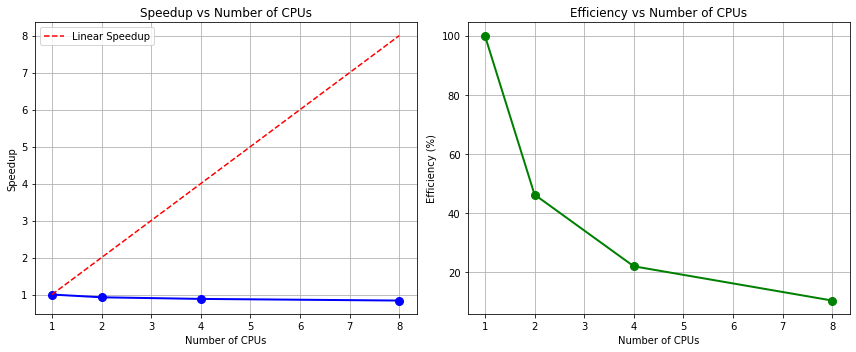


Parallel Processing Metrics:
CPUs   Time(s)    Speedup    Efficiency
1      299.00     1.00       100.00    %
2      323.00     0.93       46.28     %
4      339.00     0.88       22.05     %
8      357.00     0.84       10.47     %


In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Speedup plot
ax1.plot(cpu_counts, speedup, 'bo-', linewidth=2, markersize=8)
ax1.plot(cpu_counts, cpu_counts, 'r--', label='Linear Speedup')
ax1.set_xlabel('Number of CPUs')
ax1.set_ylabel('Speedup')
ax1.set_title('Speedup vs Number of CPUs')
ax1.grid(True)
ax1.legend()

# Efficiency plot
ax2.plot(cpu_counts, efficiency * 100, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of CPUs')
ax2.set_ylabel('Efficiency (%)')
ax2.set_title('Efficiency vs Number of CPUs')
ax2.grid(True)

plt.tight_layout()
plt.show()
print("\nParallel Processing Metrics:")
print(f"{'CPUs':<6} {'Time(s)':<10} {'Speedup':<10} {'Efficiency':<10}")
for i in range(len(cpu_counts)):
    print(f"{cpu_counts[i]:<6} {execution_times[i]:<10.2f} {speedup[i]:<10.2f} {efficiency[i]*100:<10.2f}%")

## **using Joblib**

In [20]:
!python img-multi/job.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed_2cpu.pkl --num-cpus 1 --num-images 100

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Loading data from data/coco_people_filtered_train2014.pkl
Processing 100 images using 1 CPUs
Using 1 CPU(s)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.8min finished
Saving results...

Processing Summary:
Total time: 0:04:55
Successfully processed: 100 images
Failed to process: 0 images
Average time per image: 2.952 seconds
Overall speed: 0.34 images/second


In [21]:
!python img-multi/job.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed_2cpu.pkl --num-cpus 2 --num-images 100

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Loading data from data/coco_people_filtered_train2014.pkl
Processing 100 images using 2 CPUs
Using 2 CPU(s)
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/ho

In [22]:
!python img-multi/job.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed_2cpu.pkl --num-cpus 4 --num-images 100

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Loading data from data/coco_people_filtered_train2014.pkl
Processing 100 images using 4 CPUs
Using 4 CPU(s)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/ho

In [23]:
!python img-multi/job.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed_2cpu.pkl --num-cpus 8 --num-images 100

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Loading data from data/coco_people_filtered_train2014.pkl
Processing 100 images using 8 CPUs
Using 8 CPU(s)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/ho

## Speed up and efficiency comparision for joblib in image embeddings

In [31]:
cpu_counts = np.array([1, 2, 4, 8])  # Number of CPUs
execution_times_str = np.array(["0:04:55", "0:05:04" , "0:04:58", "0:05:09"])  # Execution times in seconds
execution_times = np.array([time_to_seconds(t) for t in execution_times_str])
base_time = execution_times[0]  
speedup = base_time / execution_times
efficiency = speedup / cpu_counts

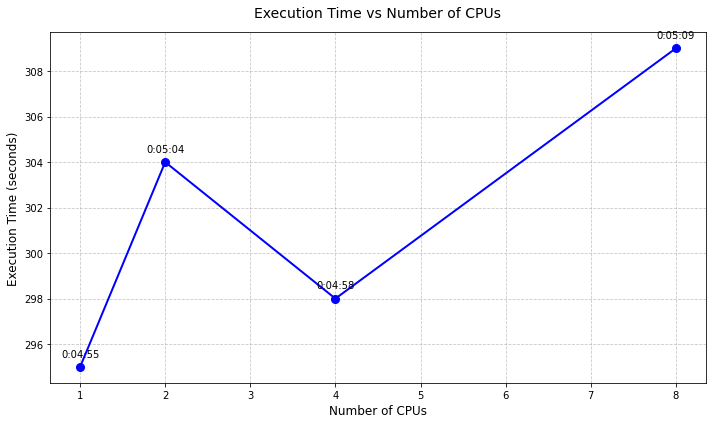

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(cpu_counts, execution_times, 'bo-', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of CPUs', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.title('Execution Time vs Number of CPUs', fontsize=14, pad=15)

# Add value labels
for i, (cpu, time) in enumerate(zip(cpu_counts, execution_times_str)):
    plt.annotate(time, (cpu, execution_times[i]), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

plt.tight_layout()
plt.show()

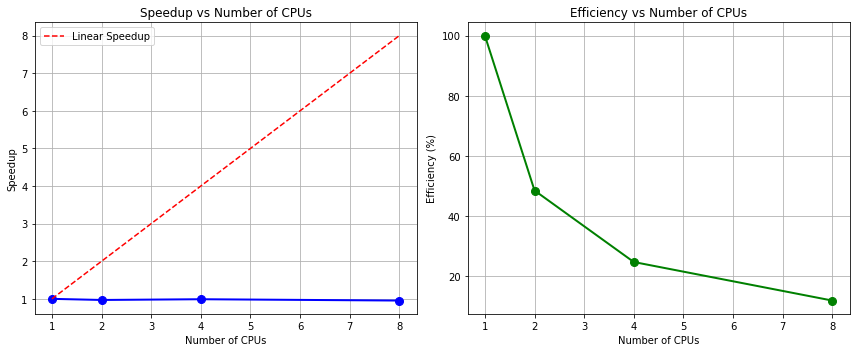


Parallel Processing Metrics:
CPUs   Time(s)    Speedup    Efficiency
1      295.00     1.00       100.00    %
2      304.00     0.97       48.52     %
4      298.00     0.99       24.75     %
8      309.00     0.95       11.93     %


In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Speedup plot
ax1.plot(cpu_counts, speedup, 'bo-', linewidth=2, markersize=8)
ax1.plot(cpu_counts, cpu_counts, 'r--', label='Linear Speedup')
ax1.set_xlabel('Number of CPUs')
ax1.set_ylabel('Speedup')
ax1.set_title('Speedup vs Number of CPUs')
ax1.grid(True)
ax1.legend()

# Efficiency plot
ax2.plot(cpu_counts, efficiency * 100, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of CPUs')
ax2.set_ylabel('Efficiency (%)')
ax2.set_title('Efficiency vs Number of CPUs')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\nParallel Processing Metrics:")
print(f"{'CPUs':<6} {'Time(s)':<10} {'Speedup':<10} {'Efficiency':<10}")
for i in range(len(cpu_counts)):
    print(f"{cpu_counts[i]:<6} {execution_times[i]:<10.2f} {speedup[i]:<10.2f} {efficiency[i]*100:<10.2f}%")

## Dask multiprocessing to convert image into image embeddings

In [2]:
!python img-multi/dasky.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed_2cpu.pkl --n-workers 1 --batch-size 32 --num-images 100

Dashboard link: http://127.0.0.1:8787/status
Using 1 workers with 1 threads each
Loading data
Processing 100 images in batches of 32...

Processed batch 1/4
Progress: 32/100 images
Speed: 0.17 images/second
ETA: 0:06:36

Processed batch 2/4
Progress: 64/100 images
Speed: 0.23 images/second
ETA: 0:02:38

Processed batch 3/4
Progress: 96/100 images
Speed: 0.25 images/second
ETA: 0:00:15

Processed batch 4/4
Progress: 100/100 images
Speed: 0.26 images/second
ETA: 0:00:00

Saving results...

Processing Summary:
Total time: 0:06:29
Successfully processed: 100 images
Failed to process: 0 images
Average time per image: 3.892 seconds
Overall speed: 0.26 images/second


In [3]:
!python img-multi/dasky.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed_2cpu.pkl --n-workers 2 --batch-size 32 --num-images 100

Dashboard link: http://127.0.0.1:8787/status
Using 2 workers with 2 threads each
Loading data
Processing 100 images in batches of 32...

Processed batch 1/4
Progress: 32/100 images
Speed: 0.17 images/second
ETA: 0:06:42

Processed batch 2/4
Progress: 64/100 images
Speed: 0.22 images/second
ETA: 0:02:40

Processed batch 3/4
Progress: 96/100 images
Speed: 0.25 images/second
ETA: 0:00:15

Processed batch 4/4
Progress: 100/100 images
Speed: 0.25 images/second
ETA: 0:00:00

Saving results...

Processing Summary:
Total time: 0:06:33
Successfully processed: 100 images
Failed to process: 0 images
Average time per image: 3.940 seconds
Overall speed: 0.25 images/second


In [6]:
!python img-multi/dasky.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed_2cpu.pkl --n-workers 4 --batch-size 16 --num-images 100

Dashboard link: http://127.0.0.1:8787/status
Using 4 workers with 4 threads each
Loading data
Processing 100 images in batches of 16...

Processed batch 1/7
Progress: 16/100 images
Speed: 0.11 images/second
ETA: 0:12:26

Processed batch 2/7
Progress: 32/100 images
Speed: 0.17 images/second
ETA: 0:06:45

Processed batch 3/7
Progress: 48/100 images
Speed: 0.20 images/second
ETA: 0:04:19

Processed batch 4/7
Progress: 64/100 images
Speed: 0.22 images/second
ETA: 0:02:42

Processed batch 5/7
Progress: 80/100 images
Speed: 0.24 images/second
ETA: 0:01:24

Processed batch 6/7
Progress: 96/100 images
Speed: 0.25 images/second
ETA: 0:00:16

Processed batch 7/7
Progress: 100/100 images
Speed: 0.25 images/second
ETA: 0:00:00

Saving results...

Processing Summary:
Total time: 0:06:37
Successfully processed: 100 images
Failed to process: 0 images
Average time per image: 3.975 seconds
Overall speed: 0.25 images/second


In [35]:
!python img-multi/dasky.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed_2cpu.pkl --n-workers 8 --batch-size 8 --num-images 100

Dashboard link: http://127.0.0.1:8787/status
Using 8 workers with 8 threads each
Loading data
Processing 100 images in batches of 8...

Processed batch 1/13
Progress: 8/100 images
Speed: 0.03 images/second
ETA: 0:46:26

Processed batch 2/13
Progress: 16/100 images
Speed: 0.06 images/second
ETA: 0:23:23

Processed batch 3/13
Progress: 24/100 images
Speed: 0.08 images/second
ETA: 0:15:25

Processed batch 4/13
Progress: 32/100 images
Speed: 0.10 images/second
ETA: 0:11:14

Processed batch 5/13
Progress: 40/100 images
Speed: 0.12 images/second
ETA: 0:08:33

Processed batch 6/13
Progress: 48/100 images
Speed: 0.13 images/second
ETA: 0:06:37

Processed batch 7/13
Progress: 56/100 images
Speed: 0.14 images/second
ETA: 0:05:08

Processed batch 8/13
Progress: 64/100 images
Speed: 0.15 images/second
ETA: 0:03:54

Processed batch 9/13
Progress: 72/100 images
Speed: 0.16 images/second
ETA: 0:02:52

Processed batch 10/13
Progress: 80/100 images
Speed: 0.17 images/second
ETA: 0:01:57

Processed batc

In [31]:
cpu_counts = np.array([1, 2, 4, 8])  # Number of CPUs
execution_times_str = np.array(["0:06:29", "0:06:33" , "0:06:37", "0:08:50"])  # Execution times in seconds
execution_times = np.array([time_to_seconds(t) for t in execution_times_str])
base_time = execution_times[0]  
speedup = base_time / execution_times
efficiency = speedup / cpu_counts

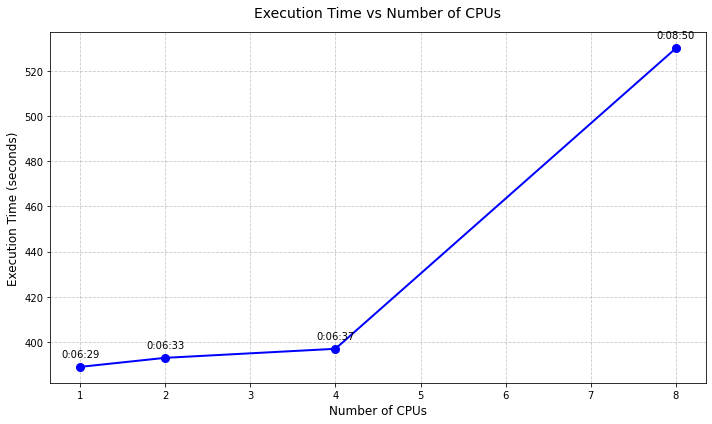

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(cpu_counts, execution_times, 'bo-', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of CPUs', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.title('Execution Time vs Number of CPUs', fontsize=14, pad=15)

# Add value labels
for i, (cpu, time) in enumerate(zip(cpu_counts, execution_times_str)):
    plt.annotate(time, (cpu, execution_times[i]), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

plt.tight_layout()
plt.show()

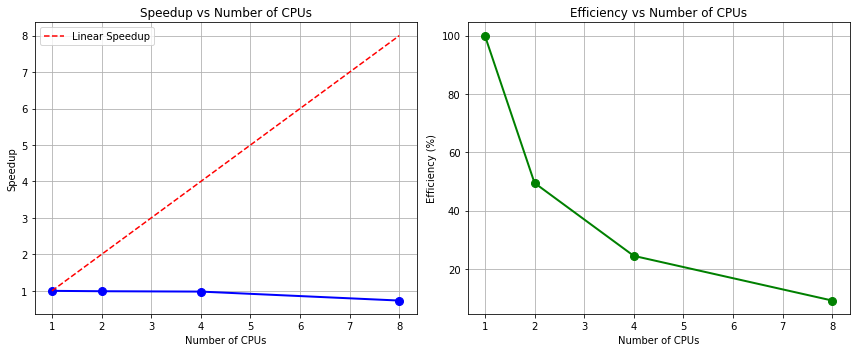

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Speedup plot
ax1.plot(cpu_counts, speedup, 'bo-', linewidth=2, markersize=8)
ax1.plot(cpu_counts, cpu_counts, 'r--', label='Linear Speedup')
ax1.set_xlabel('Number of CPUs')
ax1.set_ylabel('Speedup')
ax1.set_title('Speedup vs Number of CPUs')
ax1.grid(True)
ax1.legend()

# Efficiency plot
ax2.plot(cpu_counts, efficiency * 100, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of CPUs')
ax2.set_ylabel('Efficiency (%)')
ax2.set_title('Efficiency vs Number of CPUs')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [34]:
print("\nParallel Processing Metrics:")
print(f"{'CPUs':<6} {'Time(s)':<10} {'Speedup':<10} {'Efficiency':<10}")
for i in range(len(cpu_counts)):
    print(f"{cpu_counts[i]:<6} {execution_times[i]:<10.2f} {speedup[i]:<10.2f} {efficiency[i]*100:<10.2f}%")


Parallel Processing Metrics:
CPUs   Time(s)    Speedup    Efficiency
1      389.00     1.00       100.00    %
2      393.00     0.99       49.49     %
4      397.00     0.98       24.50     %
8      530.00     0.73       9.17      %


## Comparision with joblib, multiprocessing and dask

In [ ]:
execution_times_str_1 = np.array(["0:04:55", "0:05:04" , "0:04:58", "0:05:09"])  
execution_times_str_2 = np.array(["0:04:59", "0:05:23" , "0:05:39", "0:05:57"]) 
execution_times_str_3 = np.array(["0:06:29", "0:06:33" , "0:06:37", "0:08:50"])
exec_times_1 = np.array([time_to_seconds(t) for t in execution_times_str_1])
exec_times_2= np.array([time_to_seconds(t) for t in execution_times_str_2])
exec_times_3= np.array([time_to_seconds(t) for t in execution_times_str_3])

base_time_1 = exec_times_1[0]
base_time_2 = exec_times_2[0]
base_time_3 = exec_times_3[0]

speedup_1 = base_time_1 / exec_times_1
speedup_2 = base_time_2 / exec_times_2
speedup_3 = base_time_3 / exec_times_3


efficiency_1 = speedup_1 / cpu_counts
efficiency_2 = speedup_2 / cpu_counts
efficiency_3 = speedup_3 / cpu_counts



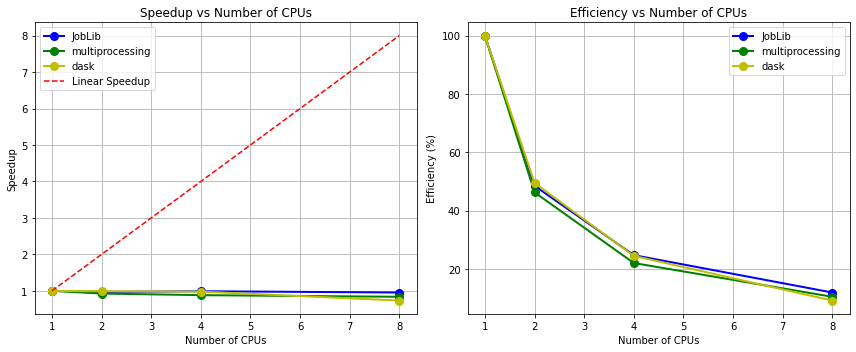

In [ ]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Speedup plot
ax1.plot(cpu_counts, speedup_1, 'bo-', linewidth=2, markersize=8, label='JobLib')
ax1.plot(cpu_counts, speedup_2, 'go-', linewidth=2, markersize=8, label='multiprocessing')
ax1.plot(cpu_counts, speedup_3, 'yo-', linewidth=2, markersize=8, label='dask')

ax1.plot(cpu_counts, cpu_counts, 'r--', label='Linear Speedup')
ax1.set_xlabel('Number of CPUs')
ax1.set_ylabel('Speedup')
ax1.set_title('Speedup vs Number of CPUs')
ax1.grid(True)
ax1.legend()

# Efficiency plot
ax2.plot(cpu_counts, efficiency_1 * 100, 'bo-', linewidth=2, markersize=8, label='JobLib')
ax2.plot(cpu_counts, efficiency_2 * 100, 'go-', linewidth=2, markersize=8, label='multiprocessing')
ax2.plot(cpu_counts, efficiency_3 * 100, 'yo-', linewidth=2, markersize=8, label='dask')

ax2.set_xlabel('Number of CPUs')
ax2.set_ylabel('Efficiency (%)')
ax2.set_title('Efficiency vs Number of CPUs')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()


## GPUs

In [9]:
!python img-multi/g2.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed-test.pkl --num-gpus 1 --num-images 100

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using 1 GPUs
Loading data...
Processing 100 images using 1 GPUs...
  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/p

In [10]:
!python img-multi/g2.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed-test.pkl --num-gpus 2 --num-images 100

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using 2 GPUs
Loading data...
Processing 100 images using 2 GPUs...
  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/bhuvaneshwaran.r/.local/lib/pytho

In [11]:
!python img-multi/g2.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed-test.pkl --num-gpus 3 --num-images 100

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using 3 GPUs
Loading data...
Processing 100 images using 3 GPUs...
  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/bhuvaneshwaran.r/.local/lib/pytho

In [12]:
!python img-multi/g2.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed-test.pkl --num-gpus 4 --num-images 100

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using 4 GPUs
Loading data...
Processing 100 images using 4 GPUs...
  0%|                                                   | 0/100 [00:00<?, ?it/s]/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/bhuvaneshwaran.r/.local/lib/pytho

## Speed up and efficiency comparision in gpus for image embeddings

In [41]:
cpu_counts = np.array([1, 2, 3, 4])  # Number of CPUs
execution_times_str = np.array(["0:02:37", "0:02:02" , "0:01:51", "0:01:45"])  # Execution times in seconds
execution_times = np.array([time_to_seconds(t) for t in execution_times_str])
base_time = execution_times[0] 
speedup = base_time / execution_times
efficiency = speedup / cpu_counts

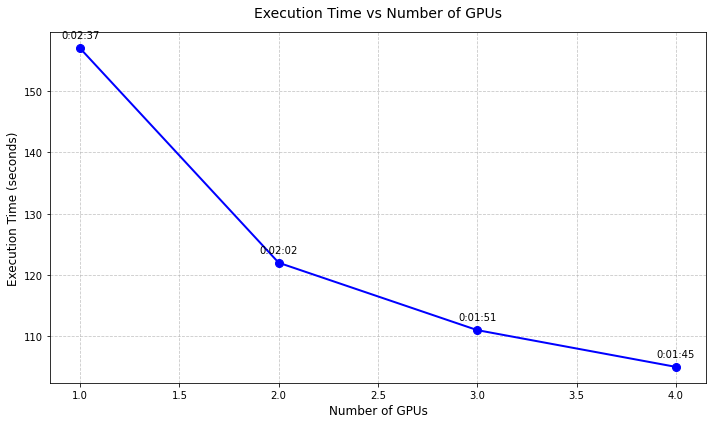

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(cpu_counts, execution_times, 'bo-', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of GPUs', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.title('Execution Time vs Number of GPUs', fontsize=14, pad=15)

# Add value labels
for i, (cpu, time) in enumerate(zip(cpu_counts, execution_times_str)):
    plt.annotate(time, (cpu, execution_times[i]), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

plt.tight_layout()
plt.show()

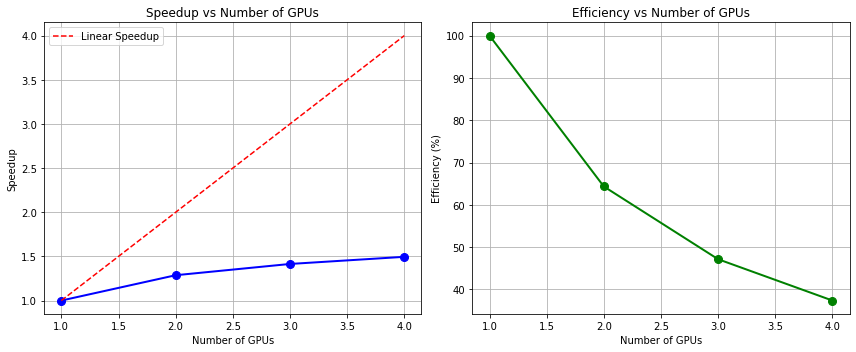


Parallel Processing Metrics:
CPUs   Time(s)    Speedup    Efficiency
1      157.00     1.00       100.00    %
2      122.00     1.29       64.34     %
3      111.00     1.41       47.15     %
4      105.00     1.50       37.38     %


In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Speedup plot
ax1.plot(cpu_counts, speedup, 'bo-', linewidth=2, markersize=8)
ax1.plot(cpu_counts, cpu_counts, 'r--', label='Linear Speedup')
ax1.set_xlabel('Number of GPUs')
ax1.set_ylabel('Speedup')
ax1.set_title('Speedup vs Number of GPUs')
ax1.grid(True)
ax1.legend()

# Efficiency plot
ax2.plot(cpu_counts, efficiency * 100, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of GPUs')
ax2.set_ylabel('Efficiency (%)')
ax2.set_title('Efficiency vs Number of GPUs')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\nParallel Processing Metrics:")
print(f"{'CPUs':<6} {'Time(s)':<10} {'Speedup':<10} {'Efficiency':<10}")
for i in range(len(cpu_counts)):
    print(f"{cpu_counts[i]:<6} {execution_times[i]:<10.2f} {speedup[i]:<10.2f} {efficiency[i]*100:<10.2f}%")

## Final Images are embedded using VAE

In [ ]:
!python img-multi/g2.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed.pkl --num-gpus 4 --num-images 48339

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using 4 GPUs
Loading data...
Processing 48339 images using 4 GPUs...
  0%|                                                 | 0/48339 [00:00<?, ?it/s]/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/bhuvaneshwaran.r/.local/lib/pyt

## Testing Caption Embeddings with CLIP model

## Multiprocessing

In [13]:
!python caption-multi/cp-multi.py --input data/coco_people_embed.pkl --output data/coco_people_embed_cpu.pkl --num-workers 1 --num-captions 1000

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

Initialization Phase:
--------------------------------------------------
Using 1 CPU workers
Loading dataset...
Extracting data...
Processing subset of 1000 captions
Total captions to process: 1000

Processing Phase:
--------------------------------------------------
Processing captions...
  0%|                                                     | 0/1 [00:00<?, ?it/s]/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11:

In [14]:
!python caption-multi/cp-multi.py --input data/coco_people_embed.pkl --output data/coco_people_embed_cpu.pkl --num-workers 2 --num-captions 1000

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

Initialization Phase:
--------------------------------------------------
Using 2 CPU workers
Loading dataset...
Extracting data...
Processing subset of 1000 captions
Total captions to process: 1000

Processing Phase:
--------------------------------------------------
Processing captions...
  0%|                                                     | 0/2 [00:00<?, ?it/s]/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11:

In [15]:
!python caption-multi/cp-multi.py --input data/coco_people_embed.pkl --output data/coco_people_embed_cpu.pkl --num-workers 4 --num-captions 1000

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

Initialization Phase:
--------------------------------------------------
Using 4 CPU workers
Loading dataset...
Extracting data...
Processing subset of 1000 captions
Total captions to process: 1000

Processing Phase:
--------------------------------------------------
Processing captions...
  0%|                                                     | 0/4 [00:00<?, ?it/s]/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11:

In [16]:
!python caption-multi/cp-multi.py --input data/coco_people_embed.pkl --output data/coco_people_embed_cpu.pkl --num-workers 8 --num-captions 1000

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

Initialization Phase:
--------------------------------------------------
Using 8 CPU workers
Loading dataset...
Extracting data...
Processing subset of 1000 captions
Total captions to process: 1000

Processing Phase:
--------------------------------------------------
Processing captions...
  0%|                                                     | 0/8 [00:00<?, ?it/s]/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11:

## Speed up and efficiency comparision for multiprocessing in text embeddings

In [45]:
cpu_counts = np.array([1, 2, 4, 8])  # Number of CPUs
execution_times = np.array([28.5, 48.3 ,50.2, 56.4])  # Execution times in seconds
base_time = execution_times[0] 
speedup = base_time / execution_times
efficiency = speedup / cpu_counts

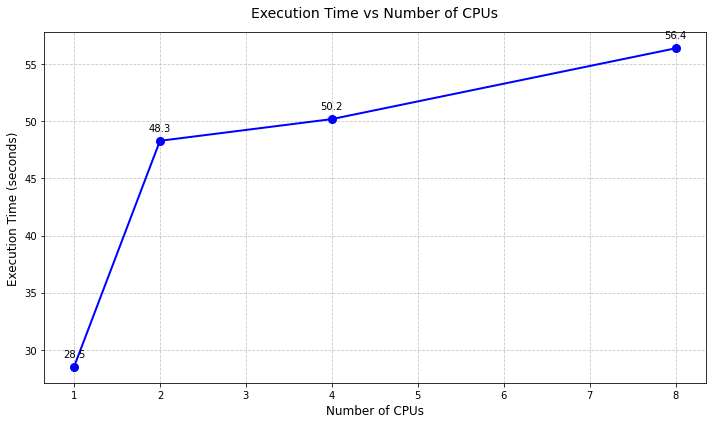

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(cpu_counts, execution_times, 'bo-', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of CPUs', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.title('Execution Time vs Number of CPUs', fontsize=14, pad=15)
for i, (cpu, time) in enumerate(zip(cpu_counts, execution_times)):
    plt.annotate(time, (cpu, execution_times[i]), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

plt.tight_layout()
plt.show()

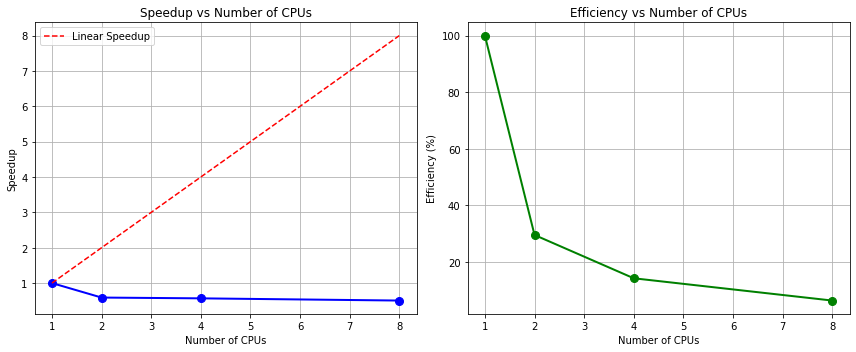

In [50]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Speedup plot
ax1.plot(cpu_counts, speedup, 'bo-', linewidth=2, markersize=8)
ax1.plot(cpu_counts, cpu_counts, 'r--', label='Linear Speedup')
ax1.set_xlabel('Number of CPUs')
ax1.set_ylabel('Speedup')
ax1.set_title('Speedup vs Number of CPUs')
ax1.grid(True)
ax1.legend()

# Efficiency plot
ax2.plot(cpu_counts, efficiency * 100, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of CPUs')
ax2.set_ylabel('Efficiency (%)')
ax2.set_title('Efficiency vs Number of CPUs')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [51]:
print("\nParallel Processing Metrics:")
print(f"{'CPUs':<6} {'Time(s)':<10} {'Speedup':<10} {'Efficiency':<10}")
for i in range(len(cpu_counts)):
    print(f"{cpu_counts[i]:<6} {execution_times[i]:<10.2f} {speedup[i]:<10.2f} {efficiency[i]*100:<10.2f}%")


Parallel Processing Metrics:
CPUs   Time(s)    Speedup    Efficiency
1      28.50      1.00       100.00    %
2      48.30      0.59       29.50     %
4      50.20      0.57       14.19     %
8      56.40      0.51       6.32      %


## Joblib for captions

In [5]:
!python caption-multi/jb.py --input data/coco_people_embed.pkl --output data/coco_people_embed_cpu.pkl --n-jobs 1 --num-captions 1000

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

Initialization Phase:
Loading dataset...
Extracting data...
Processing subset of 1000 captions
Total captions to process: 1000
Using 1 workers with 1 chunks
Chunk size: 1000 captions

Processing Phase:
Processing captions...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s finished

Actual processing time: 17.40 seconds
Average time per caption: 0.017 seconds



In [7]:
!python caption-multi/jb.py --input data/coco_people_embed.pkl --output data/coco_people_embed_cpu.pkl --n-jobs 2 --num-captions 1000

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

Initialization Phase:
Loading dataset...
Extracting data...
Processing subset of 1000 captions
Total captions to process: 1000
Using 2 workers with 2 chunks
Chunk size: 500 captions

Processing Phase:
Processing captions...
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so

In [6]:
!python caption-multi/jb.py --input data/coco_people_embed.pkl --output data/coco_people_embed_cpu.pkl --n-jobs 4 --num-captions 1000

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

Initialization Phase:
Loading dataset...
Extracting data...
Processing subset of 1000 captions
Total captions to process: 1000
Using 4 workers with 4 chunks
Chunk size: 250 captions

Processing Phase:
Processing captions...
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so

In [8]:
!python caption-multi/jb.py --input data/coco_people_embed.pkl --output data/coco_people_embed_cpu.pkl --n-jobs 8 --num-captions 1000

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

Initialization Phase:
Loading dataset...
Extracting data...
Processing subset of 1000 captions
Total captions to process: 1000
Using 8 workers with 8 chunks
Chunk size: 125 captions

Processing Phase:
Processing captions...
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so

## Speed up and efficiency comparision for joblib in text embeddings

In [52]:
cpu_counts = np.array([1, 2, 4, 8])  
execution_times = np.array([17.4, 22.5 ,22.2, 23.7]) 
base_time = execution_times[0] 
speedup = base_time / execution_times
efficiency = speedup / cpu_counts

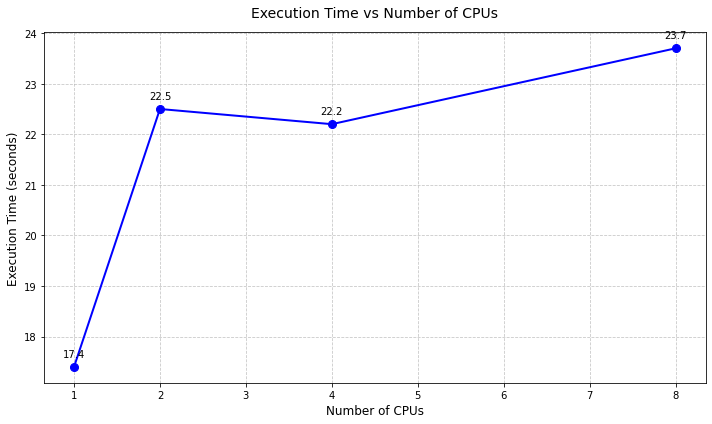

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(cpu_counts, execution_times, 'bo-', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of CPUs', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.title('Execution Time vs Number of CPUs', fontsize=14, pad=15)
for i, (cpu, time) in enumerate(zip(cpu_counts, execution_times)):
    plt.annotate(time, (cpu, execution_times[i]), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

plt.tight_layout()
plt.show()

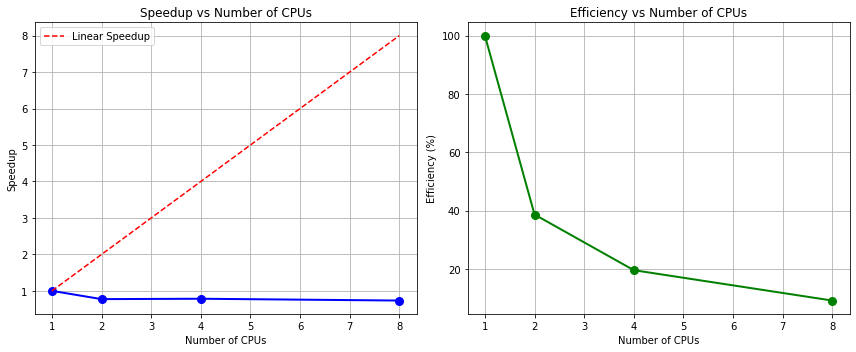


Parallel Processing Metrics:
CPUs   Time(s)    Speedup    Efficiency
1      17.40      1.00       100.00    %
2      22.50      0.77       38.67     %
4      22.20      0.78       19.59     %
8      23.70      0.73       9.18      %


In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Speedup plot
ax1.plot(cpu_counts, speedup, 'bo-', linewidth=2, markersize=8)
ax1.plot(cpu_counts, cpu_counts, 'r--', label='Linear Speedup')
ax1.set_xlabel('Number of CPUs')
ax1.set_ylabel('Speedup')
ax1.set_title('Speedup vs Number of CPUs')
ax1.grid(True)
ax1.legend()
ax2.plot(cpu_counts, efficiency * 100, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of CPUs')
ax2.set_ylabel('Efficiency (%)')
ax2.set_title('Efficiency vs Number of CPUs')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\nParallel Processing Metrics:")
print(f"{'CPUs':<6} {'Time(s)':<10} {'Speedup':<10} {'Efficiency':<10}")
for i in range(len(cpu_counts)):
    print(f"{cpu_counts[i]:<6} {execution_times[i]:<10.2f} {speedup[i]:<10.2f} {efficiency[i]*100:<10.2f}%")

## Dask multiprocessing for captions to text embeddings

In [28]:
!python caption-multi/dasky.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed_cpu.pkl --batch-size 32 --num-workers 1 --num-captions 1000


Initialization Phase:
Using 1 Dask workers
Dask dashboard available at: http://127.0.0.1:8787/status
Loading dataset
Processing subset of 1000 captions
Total captions to process: 1000

Processing Phase:
Created 32 processing tasks
Processing batches...
100%|███████████████████████████████████████████| 32/32 [00:44<00:00,  1.40s/it]

Actual processing time: 44.78 seconds
Average time per caption: 0.045 seconds

Finalization Phase:

Saving

Dataset Information:
Text embeddings shape: (1000, 512)
Attention masks shape: (1000, 77)
Number of captions processed: 1000


In [32]:
!python caption-multi/dasky.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed_cpu.pkl --batch-size 32 --num-workers 2 --num-captions 1000


Initialization Phase:
Using 2 Dask workers
Dask dashboard available at: http://127.0.0.1:8787/status
Loading dataset
Processing subset of 1000 captions
Total captions to process: 1000

Processing Phase:
Created 32 processing tasks
Processing batches...
100%|███████████████████████████████████████████| 32/32 [00:42<00:00,  1.32s/it]

Actual processing time: 42.10 seconds
Average time per caption: 0.042 seconds

Finalization Phase:

Saving

Dataset Information:
Text embeddings shape: (1000, 512)
Attention masks shape: (1000, 77)
Number of captions processed: 1000


In [37]:
!python caption-multi/dasky.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed_cpu.pkl --batch-size 64 --num-workers 4 --num-captions 1000


Initialization Phase:
Using 4 Dask workers
/shared/centos7/anaconda3/2022.05/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
Dask dashboard available at: http://127.0.0.1:8787/status
Loading dataset
Processing subset of 1000 captions
Total captions to process: 1000

Processing Phase:
Created 16 processing tasks
Processing batches...
100%|███████████████████████████████████████████| 16/16 [00:30<00:00,  1.89s/it]

Actual processing time: 30.26 seconds
Average time per caption: 0.030 seconds

Finalization Phase:

Saving

Dataset Information:
Text embeddings shape: (1000, 512)
Attention masks shape: (1000, 77)
Number of captions processed: 1000


In [ ]:
!python caption-multi/dasky.py --input data/coco_people_filtered_train2014.pkl --output data/coco_people_embed_cpu.pkl --batch-size 64 --num-workers 8 --num-captions 1000


Initialization Phase:
Using 8 Dask workers
/shared/centos7/anaconda3/2022.05/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/shared/centos7/anaconda3/2022.05/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/shared/centos7/anaconda3/2022.05/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)

In [26]:
cpu_counts = np.array([1, 2, 4, 8])  
execution_times = np.array([44.7, 42.1 ,30.2, 30.2]) 
base_time = execution_times[0] 
speedup = base_time / execution_times
efficiency = speedup / cpu_counts

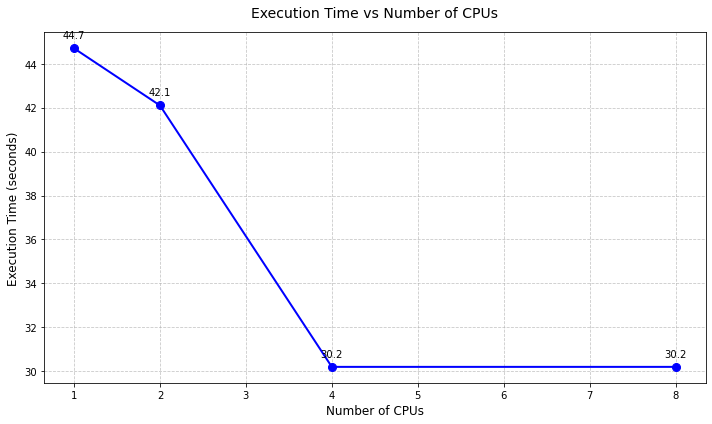

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(cpu_counts, execution_times, 'bo-', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of CPUs', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.title('Execution Time vs Number of CPUs', fontsize=14, pad=15)
for i, (cpu, time) in enumerate(zip(cpu_counts, execution_times)):
    plt.annotate(time, (cpu, execution_times[i]), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

plt.tight_layout()
plt.show()

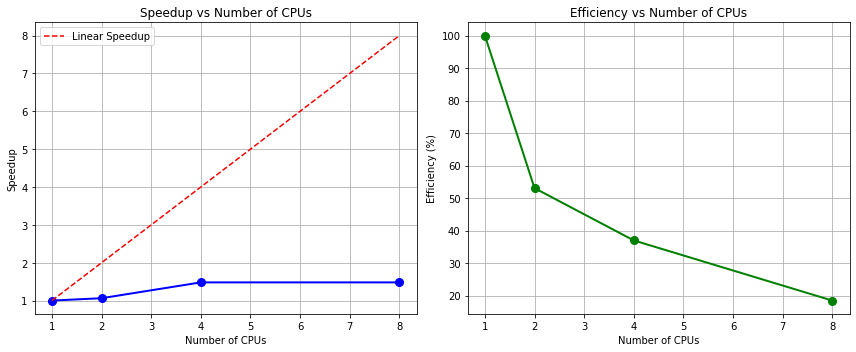

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Speedup plot
ax1.plot(cpu_counts, speedup, 'bo-', linewidth=2, markersize=8)
ax1.plot(cpu_counts, cpu_counts, 'r--', label='Linear Speedup')
ax1.set_xlabel('Number of CPUs')
ax1.set_ylabel('Speedup')
ax1.set_title('Speedup vs Number of CPUs')
ax1.grid(True)
ax1.legend()

# Efficiency plot
ax2.plot(cpu_counts, efficiency * 100, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of CPUs')
ax2.set_ylabel('Efficiency (%)')
ax2.set_title('Efficiency vs Number of CPUs')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [30]:
print("\nParallel Processing Metrics:")
print(f"{'CPUs':<6} {'Time(s)':<10} {'Speedup':<10} {'Efficiency':<10}")
for i in range(len(cpu_counts)):
    print(f"{cpu_counts[i]:<6} {execution_times[i]:<10.2f} {speedup[i]:<10.2f} {efficiency[i]*100:<10.2f}%")


Parallel Processing Metrics:
CPUs   Time(s)    Speedup    Efficiency
1      44.70      1.00       100.00    %
2      42.10      1.06       53.09     %
4      30.20      1.48       37.00     %
8      30.20      1.48       18.50     %


## Comparision of CPUs multiprocess , joblib and Dask

In [45]:
exec_times_1 = np.array([17.4, 22.5 ,22.2, 23.7])
exec_times_2= np.array([28.5, 48.3 ,50.2, 56.4])
exec_times_3= np.array([44.7, 42.1 ,30.2, 30.2]) 

base_time_1 = exec_times_1[0]
base_time_2 = exec_times_2[0]
base_time_3 = exec_times_3[0]

speedup_1 = base_time_1 / exec_times_1
speedup_2 = base_time_2 / exec_times_2
speedup_3 = base_time_3 / exec_times_3


efficiency_1 = speedup_1 / cpu_counts
efficiency_2 = speedup_2 / cpu_counts
efficiency_3 = speedup_3 / cpu_counts

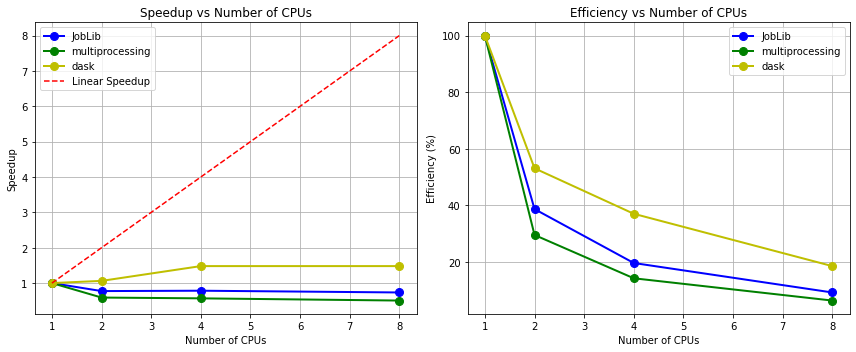

In [46]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Speedup plot
ax1.plot(cpu_counts, speedup_1, 'bo-', linewidth=2, markersize=8, label='JobLib')
ax1.plot(cpu_counts, speedup_2, 'go-', linewidth=2, markersize=8, label='multiprocessing')
ax1.plot(cpu_counts, speedup_3, 'yo-', linewidth=2, markersize=8, label='dask')

ax1.plot(cpu_counts, cpu_counts, 'r--', label='Linear Speedup')
ax1.set_xlabel('Number of CPUs')
ax1.set_ylabel('Speedup')
ax1.set_title('Speedup vs Number of CPUs')
ax1.grid(True)
ax1.legend()

# Efficiency plot
ax2.plot(cpu_counts, efficiency_1 * 100, 'bo-', linewidth=2, markersize=8, label='JobLib')
ax2.plot(cpu_counts, efficiency_2 * 100, 'go-', linewidth=2, markersize=8, label='multiprocessing')
ax2.plot(cpu_counts, efficiency_3 * 100, 'yo-', linewidth=2, markersize=8, label='dask')

ax2.set_xlabel('Number of CPUs')
ax2.set_ylabel('Efficiency (%)')
ax2.set_title('Efficiency vs Number of CPUs')
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()


## GPUs

In [2]:
!python caption-multi/multi.py --input data/coco_people_embed.pkl --output data/coco_people_embed_cpu.pkl --num-gpus 1 --num-captions 1000

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

Initialization Phase:
--------------------------------------------------
Using 1 GPUs
Loading dataset...
Extracting data...
Processing subset of 1000 captions
Total captions to process: 1000

Processing Phase:
--------------------------------------------------
Processing captions...
  0%|                                                     | 0/1 [00:00<?, ?it/s]/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWa

In [3]:
!python caption-multi/multi.py --input data/coco_people_embed.pkl --output data/coco_people_embed_cpu.pkl --num-gpus 2 --num-captions 1000

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

Initialization Phase:
--------------------------------------------------
Using 2 GPUs
Loading dataset...
Extracting data...
Processing subset of 1000 captions
Total captions to process: 1000

Processing Phase:
--------------------------------------------------
Processing captions...
  0%|                                                     | 0/2 [00:00<?, ?it/s]/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWa

In [4]:
!python caption-multi/multi.py --input data/coco_people_embed.pkl --output data/coco_people_embed_cpu.pkl --num-gpus 4 --num-captions 1000

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

Initialization Phase:
--------------------------------------------------
Using 4 GPUs
Loading dataset...
Extracting data...
Processing subset of 1000 captions
Total captions to process: 1000

Processing Phase:
--------------------------------------------------
Processing captions...
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open s

 ## Speed up and efficiency comparision for GPUs in text embedding

In [59]:
gpu_counts = np.array([1, 2, 4])
execution_times = np.array([21.7, 17.6, 11.2]) 
base_time = execution_times[0]  
speedup = base_time / execution_times
efficiency = speedup / gpu_counts

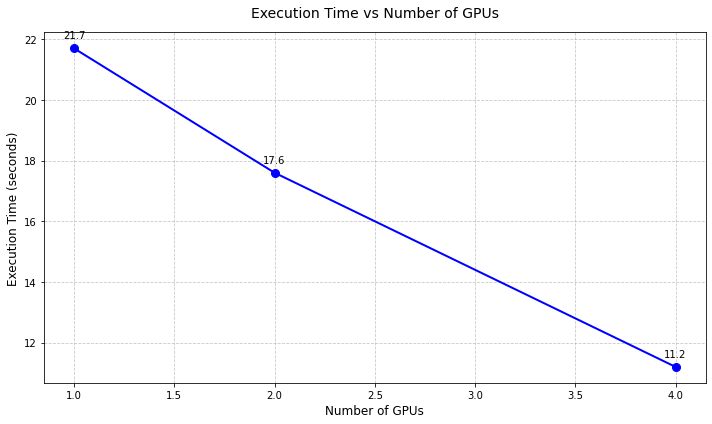

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(gpu_counts, execution_times, 'bo-', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of GPUs', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.title('Execution Time vs Number of GPUs', fontsize=14, pad=15)
for i, (cpu, time) in enumerate(zip(gpu_counts, execution_times)):
    plt.annotate(time, (cpu, execution_times[i]), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

plt.tight_layout()
plt.show()

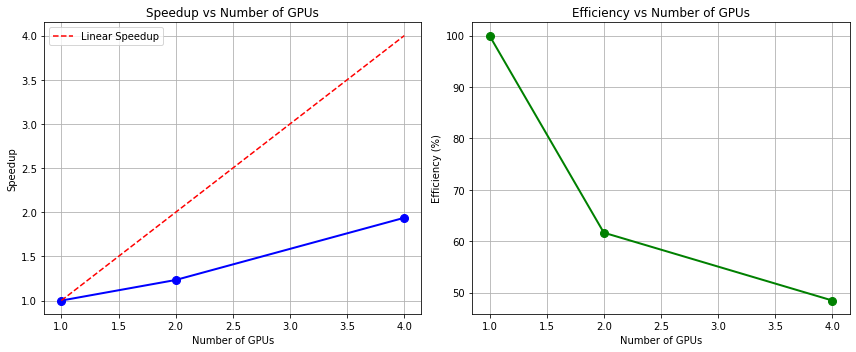

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Speedup plot
ax1.plot(gpu_counts, speedup, 'bo-', linewidth=2, markersize=8)
ax1.plot(gpu_counts, gpu_counts, 'r--', label='Linear Speedup')
ax1.set_xlabel('Number of GPUs')
ax1.set_ylabel('Speedup')
ax1.set_title('Speedup vs Number of GPUs')
ax1.grid(True)
ax1.legend()

# Efficiency plot
ax2.plot(gpu_counts, efficiency * 100, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of GPUs')
ax2.set_ylabel('Efficiency (%)')
ax2.set_title('Efficiency vs Number of GPUs')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [62]:
print("\nParallel Processing Metrics:")
print(f"{'CPUs':<6} {'Time(s)':<10} {'Speedup':<10} {'Efficiency':<10}")
for i in range(len(gpu_counts)):
    print(f"{gpu_counts[i]:<6} {execution_times[i]:<10.2f} {speedup[i]:<10.2f} {efficiency[i]*100:<10.2f}%")


Parallel Processing Metrics:
CPUs   Time(s)    Speedup    Efficiency
1      21.70      1.00       100.00    %
2      17.60      1.23       61.65     %
4      11.20      1.94       48.44     %


## Final conversion of whole caption into embeddings

In [ ]:
!python caption-multi/multi.py --input data/coco_people_embed.pkl --output data/coco_people_embed_with_caption.pkl --num-gpus 4 --num-captions 48339

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

Initialization Phase:
--------------------------------------------------
Using 4 GPUs
Loading dataset...
Extracting data...
Processing subset of 48339 captions
Total captions to process: 48339
Actual number of GPU workers being used: 4

Processing Phase:
--------------------------------------------------
Processing captions...
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python 

# Training the UNET model with noise scheduler

In [14]:
!nvidia-smi

Sat Dec  7 17:02:40 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   35C    P0    59W / 149W |   2666MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:06:00.0 Off |                    0 |
| N/A   

In [ ]:
!python train3.py --embeddings-path data/coco_people_embed_with_caption.pkl --images-path data/coco_people_filtered_train2014.pkl --batch-size 32 --save-interval 2 --eval-interval 2 --checkpoint-dir checkpoints --num-epochs 2 --num-gpus 1

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

Starting script at: 2024-12-07 19:54:03

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is requir

In [5]:
!python train3.py --embeddings-path data/coco_people_embed_with_caption.pkl --images-path data/coco_people_filtered_train2014.pkl --batch-size 32 --save-interval 2 --eval-interval 2 --checkpoint-dir checkpoints2 --num-epochs 2 --num-gpus 2

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object f

In [6]:
!python train3.py --embeddings-path data/coco_people_embed_with_caption.pkl --images-path data/coco_people_filtered_train2014.pkl --batch-size 32 --save-interval 2 --eval-interval 2 --checkpoint-dir checkpoints3 --num-epochs 2 --num-gpus 3

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object f

In [7]:
!python train3.py --embeddings-path data/coco_people_embed_with_caption.pkl --images-path data/coco_people_filtered_train2014.pkl --batch-size 32 --save-interval 2 --eval-interval 2 --checkpoint-dir checkpoints3 --num-epochs 2 --num-gpus 4

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object f

# Speed up and efficiency comparision in training the model using GPUs

In [63]:
gpu_counts = np.array([1, 2, 3, 4])  
execution_times= np.array([2579.5, 442.0, 203.6, 132.9]) 
base_time = execution_times[0] 
speedup = base_time / execution_times
efficiency = speedup / gpu_counts

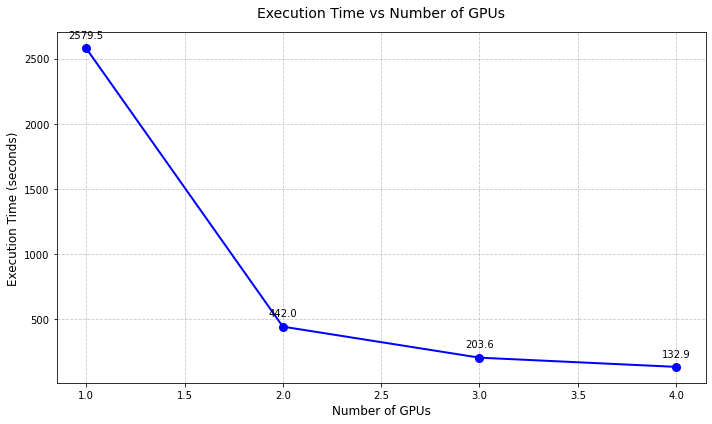

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(gpu_counts, execution_times, 'bo-', linewidth=2, markersize=8)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Number of GPUs', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.title('Execution Time vs Number of GPUs', fontsize=14, pad=15)
for i, (cpu, time) in enumerate(zip(gpu_counts, execution_times)):
    plt.annotate(time, (cpu, execution_times[i]), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

plt.tight_layout()
plt.show()

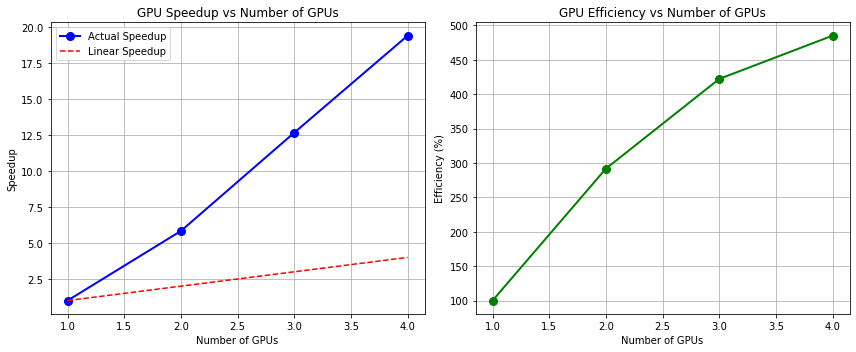

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Speedup plot
ax1.plot(gpu_counts, speedup, 'bo-', linewidth=2, markersize=8, label='Actual Speedup')
ax1.plot(gpu_counts, gpu_counts, 'r--', label='Linear Speedup')
ax1.set_xlabel('Number of GPUs')
ax1.set_ylabel('Speedup')
ax1.set_title('GPU Speedup vs Number of GPUs')
ax1.grid(True)
ax1.legend()

# Efficiency plot
ax2.plot(gpu_counts, efficiency * 100, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of GPUs')
ax2.set_ylabel('Efficiency (%)')
ax2.set_title('GPU Efficiency vs Number of GPUs')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [66]:
print("\nGPU Processing Metrics:")
print(f"{'GPUs':<6} {'Time':<10} {'Speedup':<10} {'Efficiency':<10}")
for i in range(len(gpu_counts)):
    print(f"{gpu_counts[i]:<6} {execution_times_str[i]:<10} {speedup[i]:<10.2f} {efficiency[i]*100:<10.2f}%")

print("\nTimes in seconds:")
for i in range(len(gpu_counts)):
    print(f"GPU {gpu_counts[i]}: {execution_times[i]} seconds")


GPU Processing Metrics:
GPUs   Time       Speedup    Efficiency
1      0:02:37    1.00       100.00    %
2      0:02:02    5.84       291.80    %
3      0:01:51    12.67      422.31    %
4      0:01:45    19.41      485.23    %

Times in seconds:
GPU 1: 2579.5 seconds
GPU 2: 442.0 seconds
GPU 3: 203.6 seconds
GPU 4: 132.9 seconds


# Experimenting without mixed precision for 50 epoch

In [10]:
!python train3.py --embeddings-path data/coco_people_embed_with_caption.pkl --images-path data/coco_people_filtered_train2014.pkl --batch-size 32 --save-interval 50 --eval-interval 25 --checkpoint-dir checkpoints3 --num-epochs 50 --num-gpus 4

Loading embeddings from data/coco_people_embed_with_caption.pkl
Loading image data from data/coco_people_filtered_train2014.pkl
Loading embeddings from data/coco_people_embed_with_caption.pkl
Loading image data from data/coco_people_filtered_train2014.pkl
Loading embeddings from data/coco_people_embed_with_caption.pkl
Loading image data from data/coco_people_filtered_train2014.pkl
Loading embeddings from data/coco_people_embed_with_caption.pkl
Loading image data from data/coco_people_filtered_train2014.pkl
Embeddings shape: (48339, 4, 64, 64)
Number of images: 48339
Number of matched samples: 48339
Embeddings shape: (48339, 4, 64, 64)
Number of images: 48339
Number of matched samples: 48339
Embeddings shape: (48339, 4, 64, 64)
Number of images: 48339
Number of matched samples: 48339
Embeddings shape: (48339, 4, 64, 64)
Number of images: 48339
Number of matched samples: 48339
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: Grad stri

# 50 Epoch training

In [ ]:
!python train-mixed-p.py --embeddings-path data/coco_people_embed_with_caption.pkl --images-path data/coco_people_filtered_train2014.pkl --batch-size 32 --save-interval 25 --eval-interval 25 --checkpoint-dir checkpoints4 --num-epochs 50 --num-gpus 4

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object f

## comparision of mixed precision and non mixed precision

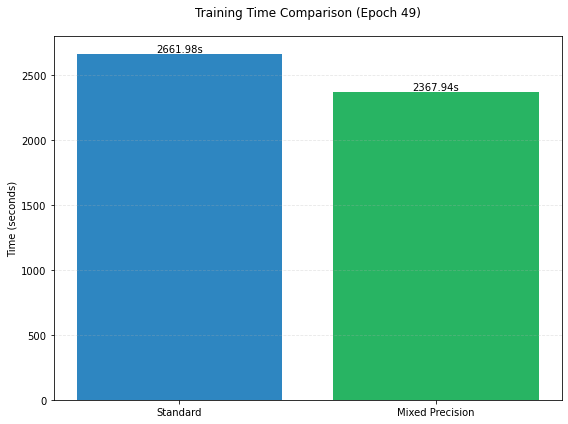

In [24]:
times = {
    'Standard': 2661.98,
    'Mixed Precision': 2367.94
}

plt.figure(figsize=(8, 6))
bars = plt.bar(times.keys(), times.values(), color=['#2E86C1', '#28B463'])
plt.title('Training Time Comparison (Epoch 49)', pad=20)
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}s',
             ha='center', va='bottom')

time_saved = times['Standard'] - times['Mixed Precision']
time_saved_percent = (time_saved / times['Standard']) * 100
plt.tight_layout()
plt.show()

# Inference

In [40]:
!python generate.py --prompt "a man in cycle" --model-path checkpoints4/checkpoint_epoch_50.pt --output-dir checkpoints4/generated_images \
    --num-inference-steps 100 \
    --guidance-scale 15 \
    --seed 42

/home/bhuvaneshwaran.r/.local/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/shared/centos7/anaconda3/2022.05/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

Using device: cuda

Loading other models...

Generating image for prompt: a man in cycle
100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 63.88it/s]
Saved image to checkpoints4/generated_images/a man in cycle.png
